In [1]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data
sales = gl.SFrame('./data/kc_house_data.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\emirl\AppData\Local\Temp\graphlab_server_1479111163.log.0


This non-commercial license of GraphLab Create for academic use is assigned to emir.lej@gmail.com and will expire on September 20, 2017.


# Create new features


In [3]:
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(np.sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(np.sqrt)
sales['bedrooms_square'] = sales['bedrooms'].apply(lambda x: x**2)

# Need to change the floors type
sales['floors'] = sales['floors'].astype(float)
# Then we can convert
sales['floors_square'] = sales['floors'].apply(lambda x: x**2)

- Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.


- On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

In [4]:
# Fit a model using all features
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (l1_penalty) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.) Note that it's important to set l2_penalty=0 to ensure we don't introduce an additional L2 penalty.

In [5]:
def create_lasso_model(sframe, features, target, l1_penalty):
    """
    Set up a lasso model using graphlab.
    """
    model = gl.linear_regression.create(sframe, target=target, features=features, validation_set=None,
                                        l2_penalty=0., l1_penalty=l1_penalty, verbose=False)    
    return model   

In [6]:
model_all = create_lasso_model(sales, all_features, target='price', l1_penalty=1e10)

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection.

**QUIZ QUESTION**: According to this list of weights, which of the features have been chosen?


In [7]:
# Print all coefficients larger than 1
print model_all.coefficients[model_all.coefficients['value'] != 0]                                  

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
+------------------+-------+---------------+--------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


# Selecting a L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:

- Split our sales data into 2 sets: training and test
- Further split our training data into two sets: train, validation


Be very careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(0.9, seed=1) # Initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1)

Next, we write a loop that does the following:
- For l1_penalty in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type np.logspace(1, 7, num=13).)
    - Fit a regression model with a given l1_penalty on TRAIN data. Specify l1_penalty=l1_penalty and l2_penalty=0. in the parameter list.
    - Compute the RSS on VALIDATION data (here you will want to use .predict()) for that l1_penalty.
    - Report which l1_penalty produced the lowest RSS on validation data.
    
When you call linear_regression.create() make sure you set validation_set = None.

Note: you can turn off the print out of linear_regression.create() with verbose = False


In [9]:
def calc_rss(predicted, output):
    """
    Calculate the residual sum of squares using the predicted data
    and the actual output.
    """
    rss = ((predicted - output)**2).sum()
    return rss

In [10]:
plot_data = [] # List to be used for plotting purposes

for l1_penalty in np.logspace(1, 7, num=13):
    # Fit model on train data
    model = create_lasso_model(training, features=all_features, target='price', l1_penalty=l1_penalty)
    # Predict using the validation data
    predicted = model.predict(validation[all_features])
    # Calculate the rss
    rss = calc_rss(predicted, validation['price'])
    # Store data to be plotted
    plot_data.append((l1_penalty, rss))

In [11]:
minrss = min([rss for _, rss in plot_data]) # Get the minimum value of rss
# Find the corresponding (l1, rss) tuple
for x in plot_data:
    if x[-1] == minrss:
        print x

(10.0, 625766285142459.9)


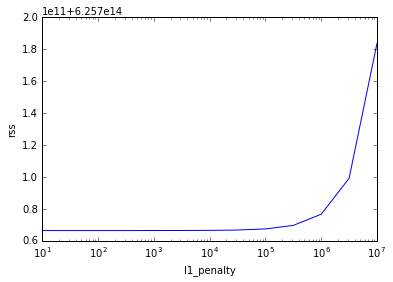

In [12]:
plt.plot(*zip(*plot_data))
plt.xscale('log')
plt.xlabel('l1_penalty')
plt.ylabel('rss')

**QUIZ QUESTION**. What was the best value for the l1_penalty? 
- Answer: 10.0




**QUIZ QUESTION** Also, using this value of L1 penalty, how many nonzero weights do you have?

In [13]:
model = create_lasso_model(training, features=all_features, target='price', l1_penalty=10.)
model.coefficients['value'].nnz() # Number of non-zero coefficients

18

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:

1. Explore a large range of l1_penalty values to find a narrow region of l1_penalty values where models are likely to have the desired number of non-zero weights.

2. Further explore the narrow region you found to find a good value for l1_penalty that achieves the desired sparsity. Here, we will again use a validation set to choose the best value for l1_penalty.

In [14]:
max_nonzeros = 7

# Exploring the larger range of values to find a narrow range with the desired sparsity

Now, implement a loop that search through this space of possible l1_penalty values:

- For l1_penalty in np.logspace(8, 10, num=20):
    - Fit a regression model with a given l1_penalty on TRAIN data. Specify l1_penalty=l1_penalty and l2_penalty=0. in the parameter list. When you call linear_regression.create() make sure you set validation_set = None
    - Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
    
**Hint:**


```python
model['coefficients']['value']

```
gives you an SArray with the parameters you learned. If you call the method .nnz() on it, you will find the number of non-zero parameters!



Let's define a wide range of possible l1_penalty_values:

In [15]:
l1_penalty_values = np.logspace(8, 10, 20)
nnz_list = []

for l1_penalty in l1_penalty_values:
    # Fit the model
    model = create_lasso_model(training, features=all_features, target='price', l1_penalty=l1_penalty)
    # Extract the number of non-zero coefficients
    nnz = model['coefficients']['value'].nnz()   
    # Append to the list
    nnz_list.append(nnz)   

In [16]:
nnz_list = np.array(nnz_list)
nnz_list
#l1_penalty_values

array([18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 15, 15, 13, 12, 10,  6,  5,
        3,  1,  1])

In [17]:
# Fint the min and max L1_values
for i, x in enumerate(nnz_list > max_nonzeros):
    if x == False:
        print i
        l1_penalty_min = l1_penalty_values[i - 1]
        l1_penalty_max = l1_penalty_values[i]        
        break

15


**QUIZ QUESTION.** What values did you find for l1_penalty_min and l1_penalty_max, respectively?


In [18]:
print l1_penalty_min
print l1_penalty_max

2976351441.63
3792690190.73


# Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set

We will now explore the narrow region of l1_penalty values we found:

- For l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max,20):
    - Fit a regression model with a given l1_penalty on TRAIN data. Specify l1_penalty=l1_penalty and l2_penalty=0. in the parameter list. When you call linear_regression.create() make sure you set validation_set = None
    - Measure the RSS of the learned model on the VALIDATION set
    - Find the model that the lowest RSS on the VALIDATION set and has sparsity equal to max_nonzeros.

In [19]:
print l1_penalty_min
print l1_penalty_max

2976351441.63
3792690190.73


In [20]:
rss_list = []
nnz_list = []
l1_list = []

l1_penalty_values = np.linspace(l1_penalty_min, l1_penalty_max, 20)

for l1_penalty in l1_penalty_values:
        
    # Fit the model
    model = create_lasso_model(training, all_features, target='price', l1_penalty=l1_penalty)
    
    # Nonzero coefficients
    nnz = model['coefficients']['value'].nnz()
    
    nnz_list.append(nnz)
    
    # Predict output
    predicted = model.predict(validation)
    
    # Calculate the rss
    rss = calc_rss(predicted, validation['price'])
    rss_list.append(rss)
    
    # Store the l1_penalty
    l1_list.append(l1_penalty)

In [21]:
# Create a SFrame to find which model has lowest rss and sparsity equal to max_nonzeros
data = gl.SFrame({"l1_penalty": l1_list, 
                  "rss" : rss_list, 
                  "nnz" : nnz_list})  

data[data['nnz'] == 7].sort('rss') # Get sorted from lowest to highest

l1_penalty,nnz,rss
3448968612.16,7,1.04693748875e+15
3491933809.48,7,1.05114762561e+15
3534899006.81,7,1.05599273534e+15
3577864204.13,7,1.06079953176e+15
